## Number of Networks

Created February 13th 2023

We plot the results of our number of networks titration.

In [1]:
from lpne.models import DcsfaNmf
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sys,os
from sklearn.preprocessing import OneHotEncoder
import torch

DATA_PATH = "/work/mk423/Anxiety/Anxiety_Network_Generation_Data.pkl"

with open(DATA_PATH,"rb") as f:
    dataDict = pickle.load(f)
    

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/hpc/home/mk423/.local/lib/python3.7/site-packages/lpne/pipelines/__init__.py:14: UserWarning: Could not load lpne/pipelines/default_params.yaml!
  warnings.warn("Could not load lpne/pipelines/default_params.yaml!")


In [2]:
dataDict.keys()

dict_keys(['X_train', 'y_train', 'y_mouse_train', 'y_exp_train', 'X_val', 'y_val', 'y_mouse_val', 'y_exp_val', 'X_test', 'y_test', 'y_mouse_test', 'y_exp_test', 'anx_info_dict', 'feature_groups', 'feature_weights'])

In [3]:
n_list = []
auc_list = []
mse_list = []
comp_list = []
for n_components in range(1,40,2):
    model = DcsfaNmf(
        n_components=n_components,
        n_intercepts=np.unique(dataDict["y_mouse_train"]).shape[0],
        optim_name="SGD",
        sup_recon_weight=0.01,
        sup_recon_type="All",
        save_folder="/hpc/home/mk423/Anxiety/MultiTaskWork/Models/lpneNumNetVal/",
        fixed_corr=["positive"],
        feature_groups=dataDict["feature_groups"],
        )
    model._initialize(5152)
    model.load_state_dict(torch.load("/hpc/home/mk423/Anxiety/MultiTaskWork/Models/lpneNumNetVal/{}_network_lpne_dcsfa_model.pt".format(n_components),map_location='cuda'))
    model.device = "cuda"
    model.encoder.eval()
    
    auc = model.score(dataDict['X_val'],dataDict['y_val'].reshape(-1,1))
    
    X_recon = model.reconstruct(dataDict['X_val'])
    mse = np.mean((X_recon - dataDict['X_val'])**2)
    
    auc_list.append(auc)
    mse_list.append(mse)
    comp_list.append(model.get_factor(0))
    n_list.append(n_components)
    

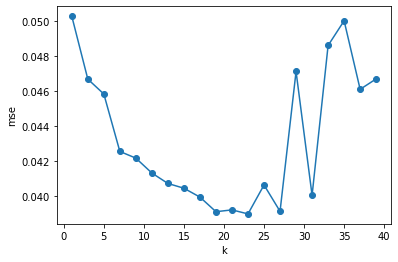

In [4]:
plt.plot(n_list,mse_list,'o-')
plt.xlabel("k")
plt.ylabel("mse")
plt.show()

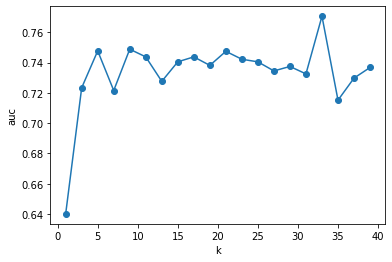

In [5]:
plt.plot(n_list,auc_list,'o-')
plt.xlabel('k')
plt.ylabel('auc')
plt.show()

In [6]:
def cosine_sim(A,B):
    return np.dot(A,B) / (np.linalg.norm(A)*np.linalg.norm(B))

W_sup = np.vstack(comp_list)
cos_sim_mat = np.ones((W_sup.shape[0],W_sup.shape[0]))

for i in range(W_sup.shape[0]):
    for j in range(W_sup.shape[0]):
        cos_sim_mat[i,j] = cosine_sim(W_sup[i,:],W_sup[j,:])

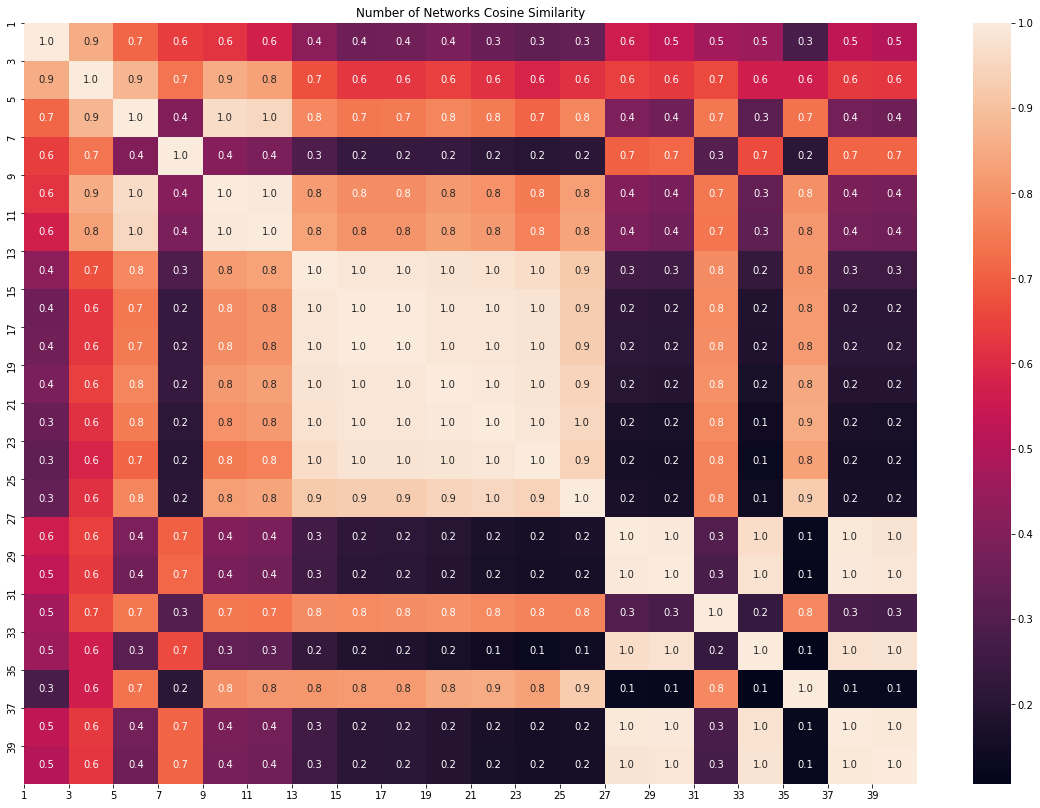

In [7]:
import seaborn as sns

plt.figure(figsize=(20,14))
sns.heatmap(cos_sim_mat,annot=True, fmt="0.1f")
plt.xticks(range(0,20),range(1,40,2))
plt.yticks(range(0,20),range(1,40,2))
plt.title("Number of Networks Cosine Similarity")
plt.show()

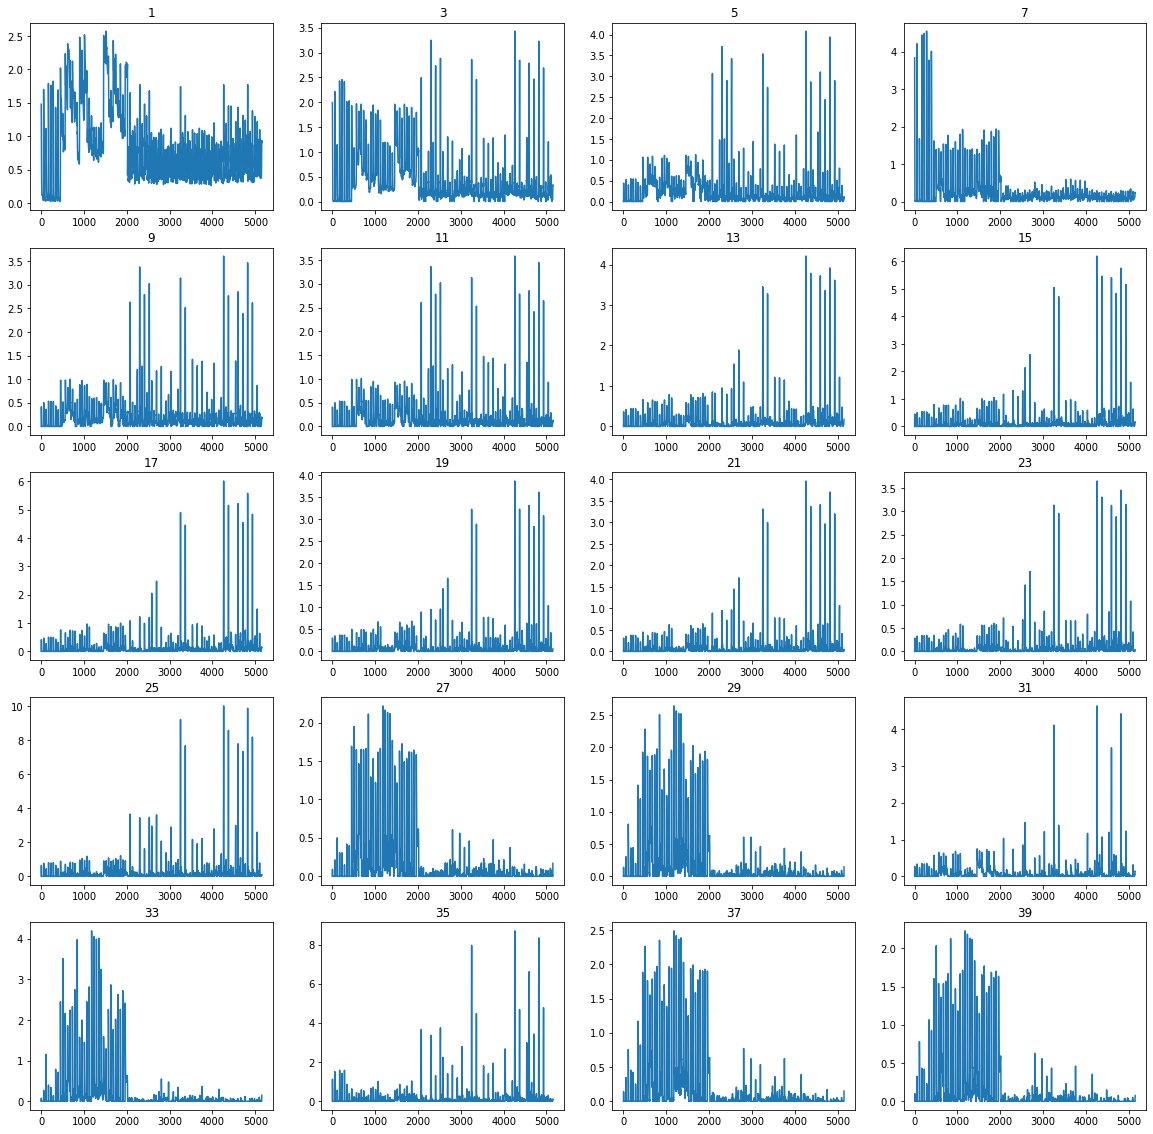

In [8]:
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.plot(W_sup[i,:])
    plt.title(i*2+1)
plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_mds.py:518: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  "The MDS API has changed. ``fit`` now constructs an"


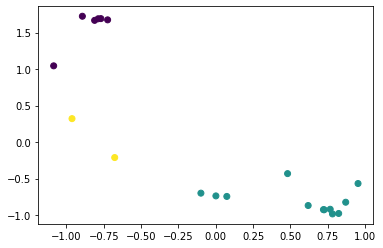

In [15]:
from sklearn.manifold import MDS
from sklearn.cluster import KMeans
mds_model = MDS()
z_mat = mds_model.fit_transform(1-cos_sim_mat)
cluster = KMeans(n_clusters=3).fit_predict(z_mat)
plt.scatter(z_mat[:,0],z_mat[:,1],c=cluster)
plt.show()